Uncomment this cell to run the notebook with TPUs 👇🏻

In [1]:
# %%capture
# ! curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# ! python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev

In [14]:
!ls -la /

total 124
drwxr-xr-x   1 root root  4096 Jan 10 21:10 .
drwxr-xr-x   1 root root  4096 Jan 10 21:10 ..
drwxr-xr-x   1 root root  4096 Jan  9 14:26 bin
drwxr-xr-x   2 root root  4096 Apr 24  2018 boot
drwxr-xr-x   1 root root  4096 Jan 10 21:00 content
drwxr-xr-x   1 root root  4096 Jan  9 14:51 datalab
drwxr-xr-x   5 root root   360 Jan 10 20:59 dev
-rwxr-xr-x   1 root root     0 Jan 10 20:59 .dockerenv
drwxr-xr-x   1 root root  4096 Jan 10 20:59 etc
drwxr-xr-x   2 root root  4096 Apr 24  2018 home
drwxr-xr-x   3 root root  4096 Jan 10 21:10 kaggle
drwxr-xr-x   1 root root  4096 Jan  9 14:28 lib
drwxr-xr-x   2 root root  4096 Jan  9 14:23 lib32
drwxr-xr-x   2 root root  4096 Oct 19 19:28 lib64
drwxr-xr-x   2 root root  4096 Oct 19 19:28 media
drwxr-xr-x   2 root root  4096 Oct 19 19:28 mnt
-rw-r--r--   1 root root 16047 Oct 28 02:53 NGC-DL-CONTAINER-LICENSE
drwxr-xr-x   1 root root  4096 Jan  9 14:52 opt
dr-xr-xr-x 171 root root     0 Jan 10 20:59 proc
drwxr-xr-x  14 root root  4096 Ja

In [15]:
try:
    from google.colab import files
    import os
    if not os.path.exists(os.path.expanduser("~/.kaggle/kaggle.json")):
        files.upload()
        #2. Series of commands to set-up for download
        !ls -lha kaggle.json
        !pip install -q kaggle # installing the kaggle package
        !mkdir -p ~/.kaggle # creating .kaggle folder where the key should be placed
        !cp kaggle.json ~/.kaggle/ # move the key to the folder

        #3. giving rw access (if 401-nathorized)
        !chmod 600 ~/.kaggle/kaggle.json
    
    #4. Sanity check if able to access kaggle
    !mkdir -p ~/kaggle/
    !kaggle datasets download -d awsaf49/rsna-bcd-roi-1024x512-png-v2-dataset -p /kaggle/input
except ImportError:
    pass

 39% 4.37G/11.1G [03:25<05:16, 22.8MB/s]
User cancelled operation


## Installation and Imports

In [3]:
%%capture
! pip install --upgrade timm
! pip install --upgrade wandb
! pip install --upgrade torchmetrics
! pip install --upgrade pytorch-lightning

In [5]:
import os
from pathlib import Path
import sys
import cv2
import glob
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from typing import Iterator, Iterable, Optional, Sequence, List, TypeVar, Generic, Sized, Union

import wandb

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Sampler

import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

import sklearn.model_selection

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize, Affine
)
import albumentations.augmentations.transforms
from albumentations.pytorch import ToTensorV2

# import warnings
# warnings.simplefilter('ignore')


## Config File and Wandb

In [6]:
try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except ImportError:
    IS_KAGGLE = False

class WandbMode:
    OFFLINE = "offline"
    ONLINE = "online"
    DISABLED = "disabled"
    
class WandbConfig:
    mode = WandbMode.ONLINE
    project = "rsna-breast"
    name = None
    save_dir = None
    log_model = "all"
    model_artifact_checkpoint_reference = None
    

class Config:
    train_bs=16
    valid_bs=16
    model_name="tf_efficientnetv2_s"
    model_params = {
      "drop_rate": 0.2,
      "drop_path_rate": 0.2
    }
    overwrite_checkpoint_hparams=True
    #train_imgs_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_256/train_images_processed_cv2_256"
    #train_imgs_path = "/kaggle/input/rsna-breast-png-roi/train_images/512/"
    #train_imgs_path = "/kaggle/input/rsna-cut-off-empty-space-from-images"
    #train_imgs_path = "/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_vl_512/train_images_processed_cv2_vl_512"
    train_imgs_path = "/kaggle/input/rsna-bcd-roi-1024x512-png-v2-dataset/train_images"
    data_has_patient_folder_sturcture = True
    train_csv_path = "/kaggle/input/rsna-breast-cancer-detection/train.csv"
    
    test_imgs_path = "/kaggle/input/rsna-breast-png-roi/test_images/256/"
    
    accelerator="auto"   # gpu or cpu
    num_devices=1
    
    
    use_pretrained=True
    epochs_count = 1
    splits_count = 1
    warmup_lr = 1e-6
    warmup_epochs = 1
    lr=3e-4
    t_max= 8   # checkme
    min_lr= 1e-6  # checkme
    weight_decay=1e-5
    pos_weight = 1
    positive_upsample_to_percent = 0.3
    precision=16 if torch.cuda.is_available() else 32 
    
    dataloader_workers_count = 4
    # aux_targets = ['BIRADS'] # not used
    
    debug=True
    debug_data_use_only_percent=0.001
    

def config_class_to_dict(config_class):
    # add recursion if needed
    return { k:v for k,v in Config.__dict__.items() if not k.startswith("__") }

In [7]:
Path(Config.train_imgs_path).exists()

False

In [ ]:
checkpoint_path = None

wandb_logger = None
wandb_artifact = None
wandb_artifact_dir = None
if WandbConfig.mode != WandbMode.DISABLED:
    wb_key = None
    if IS_KAGGLE:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        wb_key = user_secrets.get_secret("WANDB_API_KEY")
    # wandb should get key fron environment
    wandb.login(key=wb_key)

    wandb_logger = WandbLogger(
        project=WandbConfig.project,
        name = WandbConfig.name,
        offline = True if WandbConfig.mode == WandbMode.OFFLINE else False,
        save_dir = WandbConfig.save_dir,
        log_model = WandbConfig.log_model,
        group='vision',
        job_type='train',
        config=config_class_to_dict(Config)
    )

    if WandbConfig.mode == WandbMode.ONLINE and WandbConfig.model_artifact_checkpoint_reference:
        artifact = run.use_artifact(
            WandbConfig.model_artifact_checkpoint_reference, type="model")
        artifact_dir = artifact.download()
        checkpoint_path = Path(artifact_dir) / "model.ckpt"


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/loggers/wandb.py:323: UserWarning: Providing log_model=all requires wandb version >= 0.10.22 for logging associated model metadata.
Hint: Upgrade with `pip install --upgrade wandb`.
  f"Providing log_model={log_model} requires wandb version >= 0.10.22"


In [ ]:
# TODO add weight decay
def add_weight_decay(model, weight_decay=1e-5, skip_list=()):
    decay = []
    no_decay = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if len(param.shape) == 1 or np.any([v in name.lower()  for v in skip_list]):
            # print(name, 'no decay')
            no_decay.append(param)
        else:
            # print(name, 'decay')
            decay.append(param)
    return [
        {'params': no_decay, 'weight_decay': 0.},
        {'params': decay, 'weight_decay': weight_decay}]

In [ ]:
def create_test_opt_and_scheduler():
    opt = torch.optim.SGD([torch.tensor(1)], lr=Config.lr)
    scheduler1 = torch.optim.lr_scheduler.ConstantLR(opt,
                                                     factor=Config.warmup_lr/Config.lr,
                                                     total_iters=20)
    scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(
                opt, 
                T_max=Config.t_max,
                eta_min=Config.min_lr
                )
    scheduler = torch.optim.lr_scheduler.SequentialLR(opt,
                                                      schedulers=[scheduler1, scheduler2],
                                                      milestones=[Config.warmup_epochs])
    return opt, scheduler

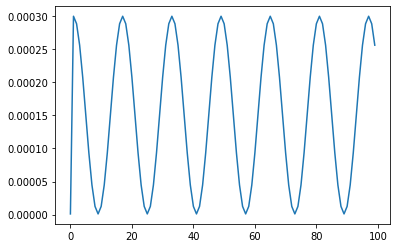

In [ ]:


def visualise_scheduler(opt, scheduler, steps=Config.epochs_count, lr=1):
    lrs = []
    for _ in range(100):
        opt.step()
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    
    fig, ax = plt.subplots()
    ax.plot(lrs)
    fig.show()
opt, scheduler = create_test_opt_and_scheduler()
visualise_scheduler(opt,
                    scheduler)

In [ ]:
def probabilistic_f1(labels, preds, beta=1):
    """
    Function taken from Awsaf's notebook:
    https://www.kaggle.com/code/awsaf49/rsna-bcd-efficientnet-tf-tpu-1vm-train
    """
    eps = 1e-5
    preds = preds.clip(0, 1)
    y_true_count = labels.sum()
    ctp = preds[labels==1].sum()
    cfp = preds[labels==0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp + eps)
    c_recall = ctp / (y_true_count + eps)
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + eps)
        return result
    else:
        return 0.0

## Dataset Class - for loading in data

In [ ]:
def display_batch(batch, figsize=(16,10), n_cols=2, maximgs=None, cmap="bone"):
    if isinstance(batch, tuple) or isinstance(batch, list):
        if len(batch) == 2:
            imgs, targets = batch
        else:
            imgs, targets, filenames = batch
    else:
        imgs = batch
        targets = None
    #targets = targets.numpy().squeeze()
    
    n = imgs.shape[0] if not maximgs else min(imgs.shape[0], maximgs)
    n_rows = math.ceil(n / n_cols)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    for i in range(n):
        x = i % n_cols
        y = i // n_cols
        ax=axs[y,x]
        im = imgs[i, :, :, :].squeeze()
        im = im.numpy().transpose((1,2,0)).squeeze()
        ax.imshow(im, cmap=cmap)
        if targets is not None:
            ax.set_title(f'Target {targets[i]}', fontsize=10)
        ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    fig.show() 

In [ ]:
def pad_images_to_max_dim(batch, pad_value = -1):
    
    # print([img.shape for img in batch])
    max_h = max([img.shape[-2] for img in batch])
    max_w = max([img.shape[-1] for img in batch])
    # pad all images in batch
    padded_batch = []
    for i, img in enumerate(batch):
        pad_left, pad_right, pad_top, pad_bottom = 0, 0, 0, 0
        diff_w = max_w - img.shape[-1]
        diff_h = max_h - img.shape[-2]
        if diff_w > 0:
            pad_left = diff_w//2
            pad_right = diff_w - pad_left
        if diff_h > 0:
            pad_top = diff_h//2
            pad_bottom = diff_h - pad_top
        if any([pad_left, pad_right, pad_top, pad_bottom]):
            padded_img = torch.nn.functional.pad(img,
                            (pad_left, pad_right, pad_top, pad_bottom),
                            value=pad_value)
            padded_batch.append(padded_img)
        else:
            padded_batch.append(img)
        
    return padded_batch

def mixed_collate_imgs_fn(batch):
    batch_soft_cpy = [x for x in batch]
    batch_imgs = [x[0] for x in batch]
    
    padded_batch = []
    padded_batch_imgs = pad_images_to_max_dim(batch_imgs)
    # for img in padded_batch_imgs:
    #     print(img.shape)
    for b_item, pad_img in zip(batch, padded_batch_imgs):
        padded_batch.append( (pad_img, *b_item[1:]))
        
    return torch.utils.data.default_collate(padded_batch)


class RSNAData(Dataset):
    def __init__(self, df,
                 img_folder,
                 resize_dim=None,
                 transform=None,
                 is_test=False,
                 has_patient_folder_sturcture=False,
                 extension="png",
                 return_filepath=False):
        self.df = df
        self.is_test = is_test
        self.transform = transform
        self.img_folder = img_folder
        self.resize_dim = resize_dim
        self.extension = extension
        self.has_patient_folder_sturcture=has_patient_folder_sturcture
        self.return_filepath=return_filepath
        
    def __getitem__(self, idx):
        row = df.loc[idx, :]
        
        if self.has_patient_folder_sturcture:
            img_path = os.path.join(self.img_folder, str(row["patient_id"]), f"{row['image_id']}.{self.extension}")
        else:
            img_path = os.path.join(self.img_folder, f"{row['image_id']}.{self.extension}")
        
        # need anydepth to load 16bit grayscale png
        # don't know if pngs are bgr or rgb
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
        if img is None:
            raise ValueError(f"No image {img_path} found")
        # cast to np float, as torch can't into uint16
        if self.resize_dim:
            img = cv2.resize(img, resize_dim)
            
        # convert to RGB for pretrained networks
        # maybe we will move it to the 
        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[0] == 1):
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
     
        img = img.astype(np.float32)
        img_max = np.amax(img)
        img_min = np.amin(img)
        img_range = img_max-img_min
        if img_range > 0:
            img = (img-img_min)/img_range
        # if np.isnan(img).sum() > 0:
        #     raise ValueError(f"Loader - Nans!")
     
        if self.transform:
            img = self.transform(image=img)['image']      
        
        # already done in transforms?
        img = torch.tensor(img, dtype=torch.float)
        
        if not self.is_test:
            target = self.df['cancer'][idx]
            #birads = self.df['BIRADS'][idx]
            # target_array = np.zeros(2, dtype=np.float32)
            # target_array[target] = 1.0
            # target = torch.tensor(target_array, dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
            #birads = torch.tensor(birads, dtype=torch.float32)
            # TODO - add BIRADS?
            if self.return_filepath:
                return img, target, img_path
            return (img, target)
        if self.return_filepath:
            return img, target
        return (img)
    
    def __len__(self):
        return len(self.df)

In [ ]:
y= pad_images_to_max_dim([torch.tensor(np.random.rand(256,256)),
                          torch.tensor(np.random.randn(100,50))])
[x.shape for x in y]

[torch.Size([256, 256]), torch.Size([256, 256])]

In [ ]:
# Load the data and pass it onto the training function
df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
df['img_name'] = df['patient_id'].astype(str) + "/" + df['image_id'].astype(str) + ".png"
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,img_name
0,1,17638,1735151780,R,CC,45.0,0,0,0,0.0,1,C,49,True,17638/1735151780.png
1,1,25687,1537402893,L,MLO,55.0,0,0,0,1.0,0,C,49,False,25687/1537402893.png
2,1,19577,937961553,R,CC,67.0,0,1,0,0.0,0,B,49,True,19577/937961553.png
3,1,20400,1485611061,L,MLO,52.0,0,0,0,NaN,0,B,210,False,20400/1485611061.png
4,2,9394,1296540996,L,MLO,61.0,0,0,0,NaN,0,NaN,48,False,9394/1296540996.png


## Basic Image Augmentations

In [ ]:

train_augments = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Affine(rotate=(-10,10), p=0.2),
    Normalize (mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=1.0, p=1.0),
    ToTensorV2(p=1.0)
],p=1.)
    
valid_augments = Compose([
    Normalize (mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=1.0, p=1.0),
    ToTensorV2(p=1.0)
], p=1.)

In [ ]:
# TODO
class PositiveNegativeIndicesSampler(Sampler[int]):

    def __init__(self, positive_indices, negative_indices, num_samples,
                 negatives_per_batch, batch_size,
                 generator=None) -> None:
        if not isinstance(num_samples, int) or isinstance(num_samples, bool) or \
                num_samples <= 0:
            raise ValueError("num_samples should be a positive integer "
                             "value, but got num_samples={}".format(num_samples))

        self.positive_indices = positive_indices
        self.negative_indices = negative_indices
        self.num_samples = num_samples
        self.generator = generator

    def __iter__(self) -> Iterator[int]:
        rand_tensor = torch.multinomial(self.weights, self.num_samples, self.replacement, generator=self.generator)
        yield from iter(rand_tensor.tolist())

    def __len__(self) -> int:
        return self.num_samples

In [ ]:
def class_weight(class_array, upsample_cancer_to_percent):
    has_cancer = class_array.astype(np.float64)
    
    dataset_len = len(has_cancer)
    cancer_len = len(has_cancer[has_cancer > 0])
    non_cancer_len = dataset_len-cancer_len
    
    x = non_cancer_len*upsample_cancer_to_percent / (cancer_len -  upsample_cancer_to_percent*cancer_len)
    
    has_cancer[has_cancer > 0] = x
    has_cancer[has_cancer <= 0 ] = 1
    return has_cancer

## Model Class using `pl.LightningModule` ⚡️

In [ ]:
class_weight( np.concatenate((np.zeros(9),np.ones(1))),  0.5)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 9.])

In [ ]:
class RSNAModel(pl.LightningModule):
    def __init__(self, base_model,
                 lr,
                 warmup_lr,
                 warmup_epochs,
                 t_max,
                 min_lr,
                 weight_decay,
                 features_size=None,
                 pos_weight=None,   
                ):
        super().__init__()
        # save_hyperparameters() is used to specify which init arguments should 
        # be saved in the checkpoint file to be used to instantiate the model
        # from the checkpoint later.
        self.save_hyperparameters(ignore=["base_model", "features_size"])
        # Model Architecture
        self.model = base_model
        classes_count = 1
        if not features_size:
            features_size = base_model(torch.randn(1, 3, 512, 512)).shape[-1]
        self.fc = nn.Linear(features_size, classes_count)
        
        # Loss functions
        # CHECKME - I believe that positive weight could not work here after re-loading model
        pos_weight=None if pos_weight is None else torch.tensor([pos_weight], dtype=torch.float32)
        self.train_loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.valid_loss = nn.BCEWithLogitsLoss()

        # Metric
        self.roc_auc = torchmetrics.classification.BinaryAUROC()
        self.pr_curve = torchmetrics.classification.BinaryPrecisionRecallCurve()
        self.valid_stat_scores = torchmetrics.classification.BinaryStatScores()
        self.train_stat_scores = torchmetrics.classification.BinaryStatScores()
        self.binary_f1 = torchmetrics.F1Score(task='binary')
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr,
                               weight_decay=self.hparams.weight_decay)

        scheduler1 = torch.optim.lr_scheduler.ConstantLR(opt,
                                                         factor=self.hparams.warmup_lr/self.hparams.lr,
                                                         total_iters=self.hparams.warmup_epochs)
        scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(
                        opt, 
                        T_max=self.hparams.t_max,
                        eta_min=self.hparams.min_lr
                     )
        sch = torch.optim.lr_scheduler.SequentialLR(opt,
                                                    schedulers=[scheduler1, scheduler2],
                                                    milestones=[self.hparams.warmup_epochs])
        
        return [opt], [sch]
        
    def forward(self, x):
        features = self.model(x)
        output = self.fc(features)
        return output
    
    def training_step(self, batch, batch_idx):
        imgs = batch[0]
        target = batch[1].unsqueeze(-1)
        
        out = self(imgs)
        positive_outcomes_mean = out[out>=0].mean()
        negative_outcomes_mean = out[out<0].mean()
        cancer_percent = target[target>0].shape[0]/target.shape[0]
        
        predictions = F.sigmoid(out)
        
        # shall we compute every x epochs? (but we will loose epoch metrics!)
        true_positives, false_positives, true_negatives, false_negatives, sup = self.train_stat_scores(predictions, target)
        train_loss = self.train_loss(out, target)
        to_log = {'train/loss': train_loss.item(),
                  'train/positive_outcomes_mean': positive_outcomes_mean.item(),
                  'train/negative_outcomes_mean': negative_outcomes_mean.item(),
                  'train/accuracy': ((true_positives+true_negatives)/(true_positives+false_positives+true_negatives+false_negatives)).item(),
                  'train/precision': (true_positives/(true_positives+false_positives)).item(),
                  'train/recall': (true_positives/(true_positives+false_negatives)).item()
                 }
        self.log_dict(to_log)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        imgs = batch[0]
        target = batch[1].unsqueeze(-1)
        
        out = self(imgs)
        
        valid_loss = self.valid_loss(out, target)
        
        predictions = F.sigmoid(out)
          
        f1_current = self.binary_f1(predictions, target)
        self.roc_auc(predictions, target)
        self.valid_stat_scores(predictions, target)
        self.log_dict({"valid/loss": valid_loss.item(),
                       "valid/f1": f1_current.item()})     
        return valid_loss
    
    def training_epoch_end(self, outputs):
        true_positives, false_positives, true_negatives, false_negatives, sup = self.train_stat_scores.compute()
        to_log = {
                  'train/precision_epoch': (true_positives/(true_positives+false_negatives)).item(),
                  'train/recall_epoch': (true_positives/(true_positives+false_negatives)).item(),
                  'train/specificity_epoch': (true_negatives/(true_negatives+false_positives)).item()}
        self.log_dict(to_log) 
        self.train_stat_scores.reset()
    
    def validation_epoch_end(self, outputs):
        true_positives, false_positives, true_negatives, false_negatives, sup = self.valid_stat_scores.compute()
        to_log = {'valid/roc_auc_epoch': self.roc_auc.compute().item(),
                  'valid/f1_epoch': self.binary_f1.compute().item(),
                  'valid/precision_epoch': (true_positives/(true_positives+false_positives)).item(),
                  'valid/recall_epoch': (true_positives/(true_positives+false_negatives)).item(),
                  'valid/specificity_epoch': (true_negatives/(true_negatives+false_positives)).item()}
        self.log_dict(to_log) 
        self.binary_f1.reset()
        self.roc_auc.reset()
        self.valid_stat_scores.reset()
        
    # def test_step(self, batch, batch_idx):
    #    loss, acc = self._shared_eval_step(batch, batch_idx)
    #    metrics = {"test_acc": acc, "test_loss": loss}
    #    self.log_dict(metrics)
    #    return metrics
    


config_hparams_dict = dict(
    lr=Config.lr,
    warmup_lr=Config.warmup_lr,
    warmup_epochs=Config.warmup_epochs,
    t_max=Config.t_max,
    min_lr=Config.min_lr,
    weight_decay=Config.weight_decay,
    pos_weight=Config.pos_weight)

In [ ]:
tb_logger = TensorBoardLogger(save_dir="tb_logs", name="rsna-breast-model")
loggers = [x for x in [wandb_logger, tb_logger] if x is not None]

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    monitor="valid/f1_epoch",
    filename="ckpt_epoch={epoch:02d}_validf1={valid/f1_epoch:02.0f}",
    auto_insert_metric_name=False,
    save_top_k=3,
    mode="max",
    save_last=True,
    every_n_epochs=3)

## Main loop

In [ ]:


# add stratified k folds when ready
kfold = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=Config.splits_count, train_size=0.8)
for fold_, (train_idx, valid_idx) in enumerate(kfold.split(df, df['cancer'].values)):
    print(f"{'='*40} Fold: {fold_} / {Config.splits_count-1} {'='*40}")


    train_df = df.loc[train_idx].reset_index(drop=True).copy()
    valid_df = df.loc[valid_idx].reset_index(drop=True).copy()
        
    if Config.debug:
        train_df = train_df.iloc[:int(len(train_df)*Config.debug_data_use_only_percent), :]
        valid_df = train_df.iloc[:int(len(valid_df)*Config.debug_data_use_only_percent), :]
    
    train_rows_weight = class_weight(train_df["cancer"].values, Config.positive_upsample_to_percent)   

    print(f"Train df len {len(train_df)}, cancers {train_df['cancer'].sum()}, percent {train_df['cancer'].sum()/len(train_df)}")
    print(f"Valid df len {len(valid_df)}, cancers {valid_df['cancer'].sum()}, percent {valid_df['cancer'].sum()/len(valid_df)}")        
    print(f"In train dataset cancer will be upsampled to percent {train_rows_weight[train_rows_weight>1].sum()/train_rows_weight.sum()}")
    
    train_dataset = RSNAData(
        df = train_df,
        img_folder = Config.train_imgs_path,
        has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
        transform=train_augments
    )
    valid_dataset = RSNAData(
        df = valid_df,
        img_folder = Config.train_imgs_path,
        has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
        transform = valid_augments
    )
    train_loader = DataLoader(
        train_dataset,
        batch_size=Config.train_bs,
        sampler=torch.utils.data.sampler.WeightedRandomSampler(train_rows_weight, len(train_df)),
        num_workers=Config.dataloader_workers_count,
        collate_fn=mixed_collate_imgs_fn,
        pin_memory=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=Config.train_bs,
        shuffle=False,
        num_workers=Config.dataloader_workers_count,
        collate_fn=mixed_collate_imgs_fn,
        pin_memory=True
    )
    # CHECKME after introducing k-fold start with fresh copy of base model
    
    if checkpoint_path:
        if Config.overwrite_checkpoint_hparams:
            hparams = config_hparams_dict
        else:
            hparams = {}
        model = RSNAModel.load_from_checkpoint(checkpoint_path, 
                                              **hparams)
    else:   
        # it turns that i have lower LB than other kagglers using efficientnet.
        # i have forgotten to set the drop path rate. Here is the fixed:
        # efficientnet_b2(pretrained=True, drop_rate = 0.3, drop_path_rate = 0.2)
        model_name = Config.model_name
        base_model = timm.create_model(model_name, 
                                       pretrained=Config.use_pretrained,
                                       **Config.model_params
                                      ) 
        model = RSNAModel(base_model,
                          **config_hparams_dict)
    
    trainer = pl.Trainer(
        max_epochs=Config.epochs_count,
        accelerator=Config.accelerator,
        devices=Config.num_devices,
        precision=Config.precision,
        logger = loggers,
        callbacks=[checkpoint_callback]
    )
    trainer.fit(model, train_loader, valid_loader)
    wandb.finish()

======================================== Fold: 0 / 0 ========================================
Train df len 43, cancers 2, percent 0.046511627906976744
Valid df len 10, cancers 0, percent 0.0
In train dataset cancer will be upsampled to percent 0.3


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1599: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs

Training: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch,▁▁
train/precision_epoch,▁
train/recall_epoch,▁
train/specificity_epoch,▁
trainer/global_step,▁▁
valid/f1,▁
valid/f1_epoch,▁
valid/loss,▁
valid/precision_epoch,▁
valid/roc_auc_epoch,▁
valid/specificity_epoch,▁


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 3, 1024, 512])
tensor([-0.5293, -0.5895, -0.5249, -0.5990, -0.1383, -0.5018, -0.5615, -0.5099,
        -0.1707, -0.6850, -0.0912, -0.0356, -0.5027, -0.5659, -0.2283, -0.6516])
tensor(-1.)
tensor(1.)
tensor([0.2354, 0.2052, 0.2375, 0.2005, 0.4309, 0.2491, 0.2192, 0.2451, 0.4146,
        0.1575, 0.4544, 0.4822, 0.2486, 0.2170, 0.3858, 0.1742])


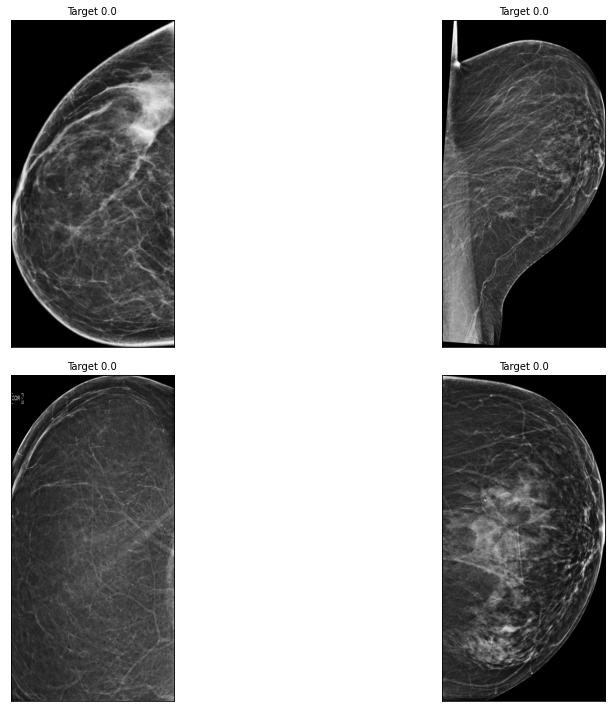

In [ ]:
train_dataset = RSNAData(
    df = df,
    img_folder = Config.train_imgs_path,
    has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
    # img_folder = "/kaggle/input/rsna-breast-png-roi/train_images/256/",
    #img_folder = "/kaggle/input/rsna-cut-off-empty-space-from-images",
    transform=train_augments
)

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.train_bs,
    shuffle=True,
    num_workers=1,
    collate_fn=mixed_collate_imgs_fn
)
minibatch = next(iter(train_loader))
print(minibatch[0].shape)
print(minibatch[0].mean((1,2,3)))
print(minibatch[0].min())
print(minibatch[0].max())
minibatch[0] += 1.0
minibatch[0] /= 2.0
print(minibatch[0].mean((1,2,3)))

display_batch(minibatch, maximgs=4)

In [ ]:
x_dataset = RSNAData(
    df = df,
    img_folder = Config.train_imgs_path,
    has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
    # img_folder = "/kaggle/input/rsna-breast-png-roi/train_images/256/",
    #img_folder = "/kaggle/input/rsna-cut-off-empty-space-from-images",
    transform=ToTensorV2(),
    return_filepath=True
)

weighted_x_loader = DataLoader(
    x_dataset,
    batch_size=Config.train_bs,
    sampler=torch.utils.data.sampler.WeightedRandomSampler(
        class_weight(df["cancer"].values, Config.positive_upsample_to_percent),
        len(df),
        replacement=False),
    num_workers=Config.dataloader_workers_count,
    collate_fn=mixed_collate_imgs_fn,
)

#if Config.debug or True:
#    for minibatch in weighted_x_loader:
#        imgs = minibatch[0]
#        if torch.isnan(minibatch[0]).sum() > 0:
#            raise ValueError("bad pixel values")
#        if torch.isnan(minibatch[1]).sum() > 0:
#            raise ValueError("bad targets values")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

tensor([0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.])

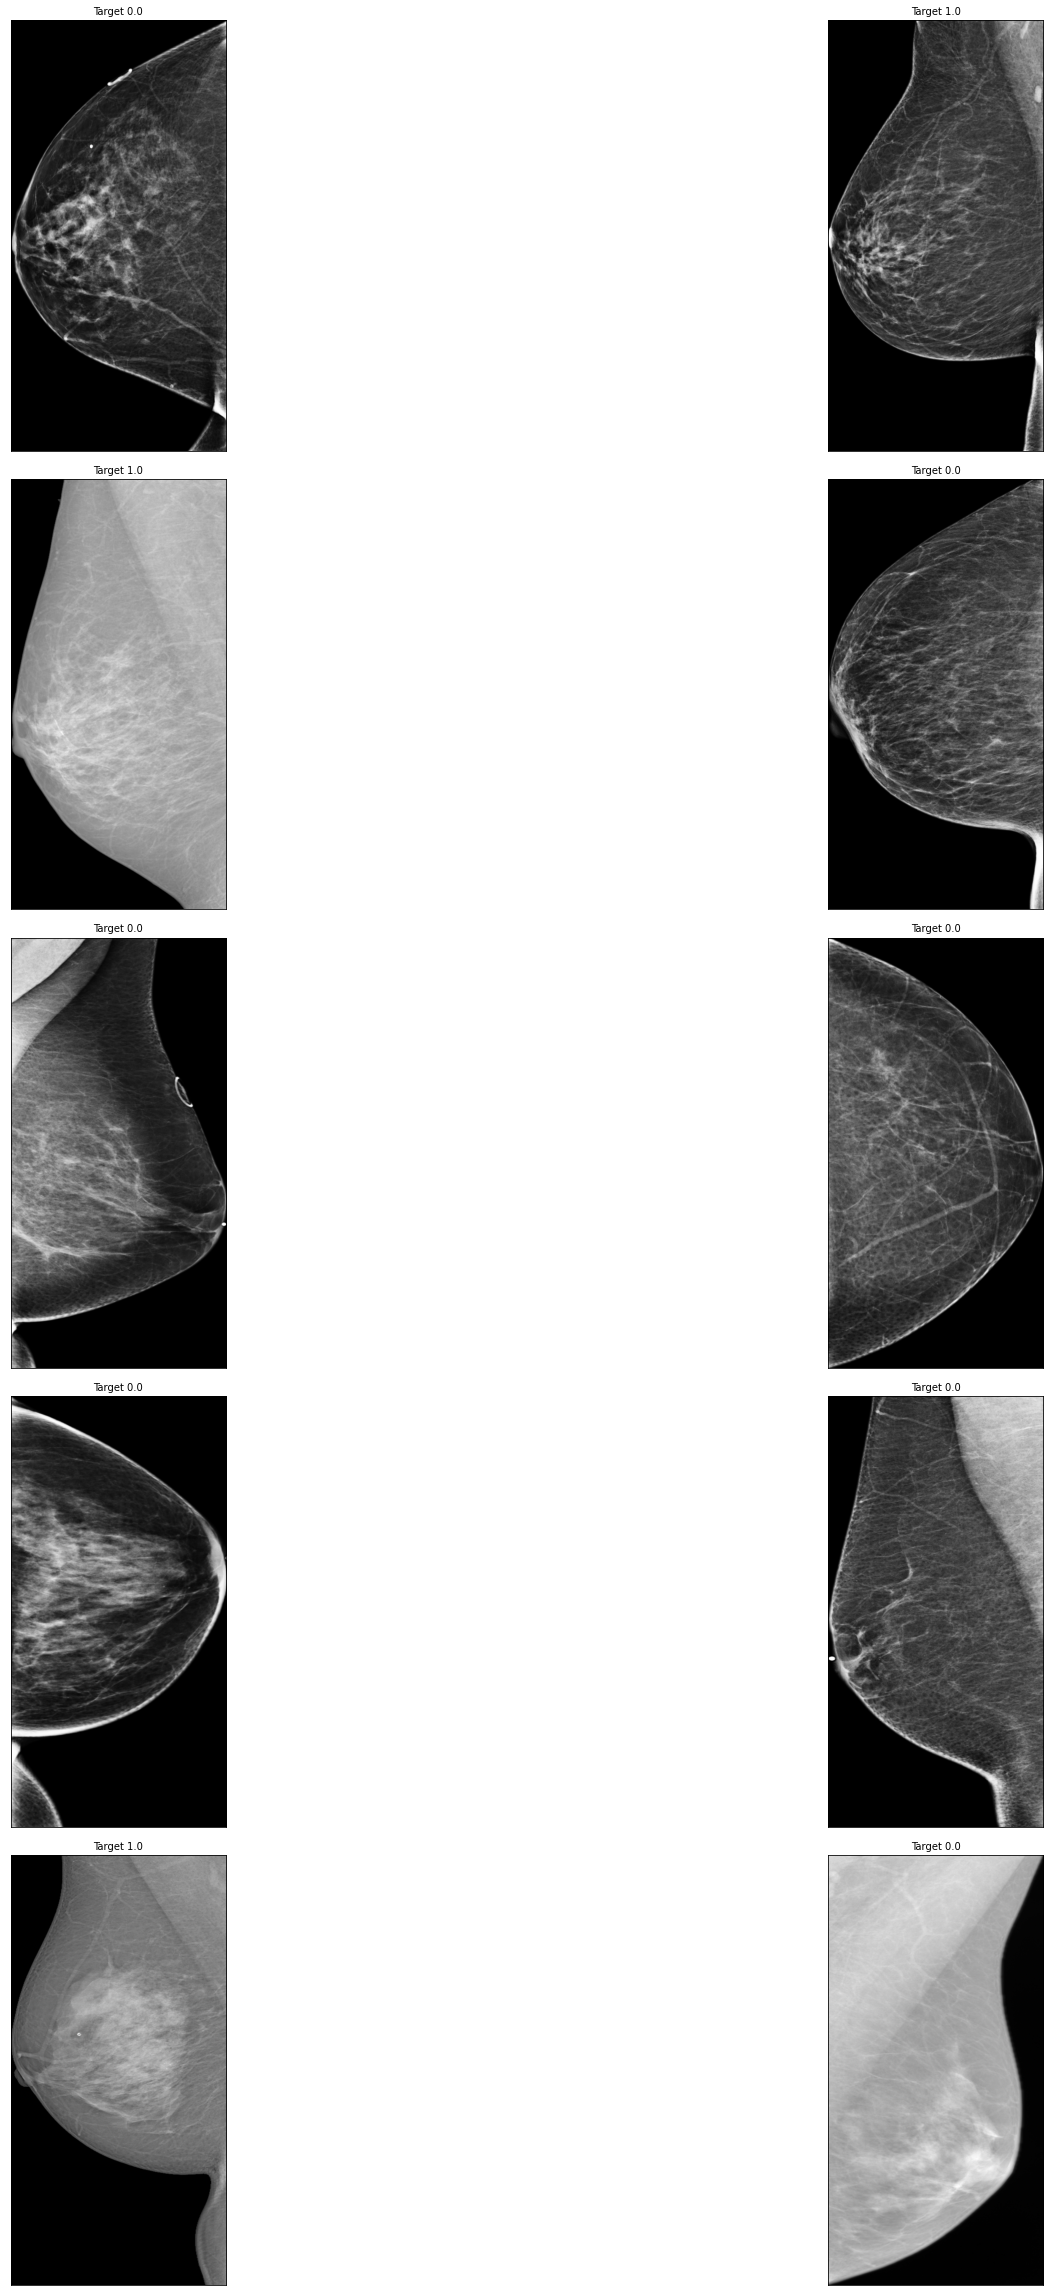

In [ ]:
minibatch = next(iter(weighted_x_loader))
display_batch(minibatch, maximgs=10,figsize=(32,32))
minibatch[1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

torch.Size([16, 3, 1024, 512])
tensor([-0.0227, -0.5659, -0.6596, -0.6907, -0.5719,  0.0575, -0.5814, -0.1730,
        -0.5927, -0.1258, -0.5596, -0.0927, -0.5995, -0.3747, -0.2233, -0.4732])
tensor(-1.)
tensor(1.)
tensor(0)
tensor([0.4886, 0.2170, 0.1702, 0.1547, 0.2141, 0.5288, 0.2093, 0.4135, 0.2037,
        0.4371, 0.2202, 0.4537, 0.2002, 0.3126, 0.3883, 0.2634])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

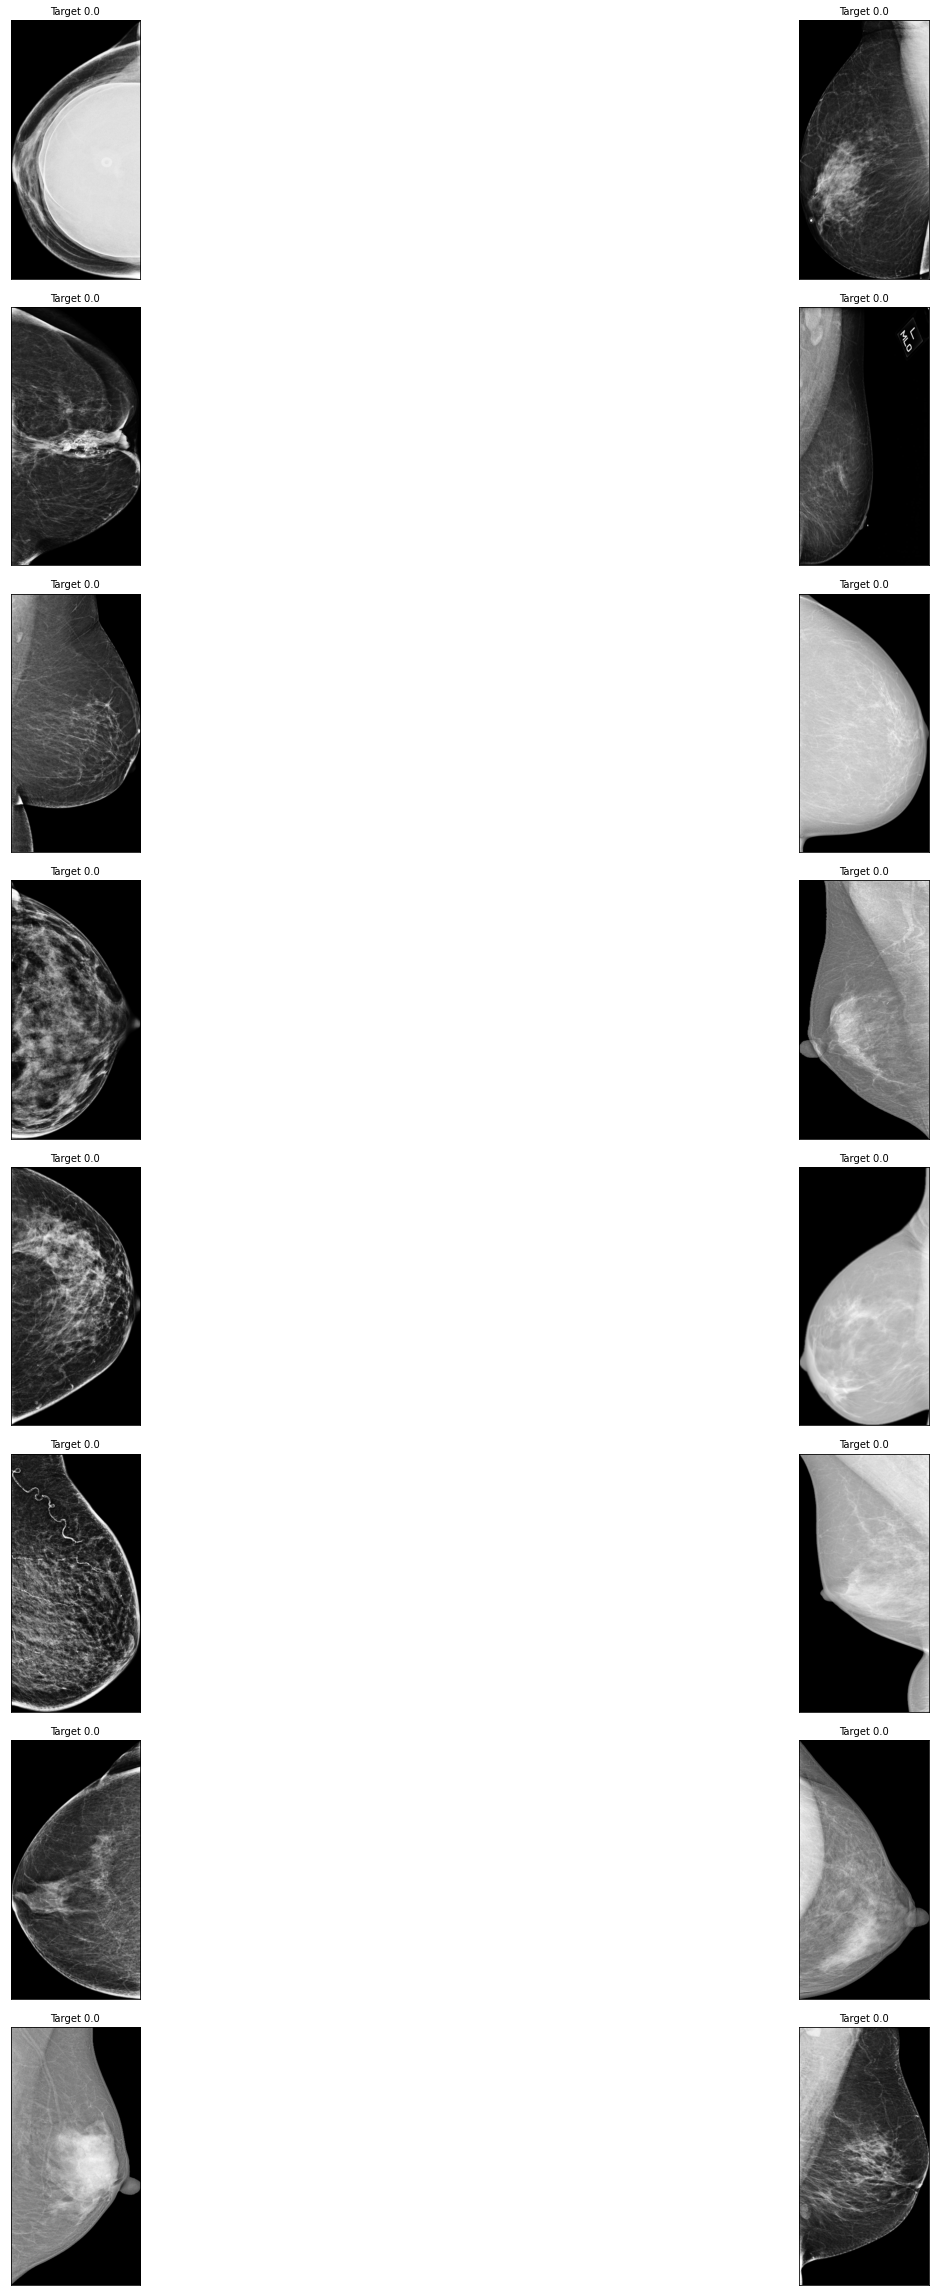

In [ ]:
v_dataset = RSNAData(
    df = df,
    img_folder = Config.train_imgs_path,
    has_patient_folder_sturcture = Config.data_has_patient_folder_sturcture,
    transform = valid_augments
)
v_loader = DataLoader(
    v_dataset,
    batch_size=Config.train_bs,
    shuffle=False,
    num_workers=Config.dataloader_workers_count,
    collate_fn=mixed_collate_imgs_fn,
    pin_memory=True
)
minibatch = next(iter(v_loader))
print(minibatch[0].shape)
print(minibatch[0].mean((1,2,3)))
print(minibatch[0].min())
print(minibatch[0].max())
print(torch.isnan(minibatch[0]).sum())
minibatch[0] += 1.0
minibatch[0] /= 2.0
print(minibatch[0].mean((1,2,3)))
    
display_batch(minibatch, maximgs=20,figsize=(32,32))

minibatch[1]


In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=tb_logs/